In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [4]:
raw_transcripts = pd.read_csv("../data/posts_transcripts.csv", encoding='utf-8')
data_posts_hashtags= pd.read_csv("../data/hashtags_posts.csv", encoding='utf-8')
#data_posts_profiles= pd.read_csv("../data/post_profile_hashtags_as_array.csv", encoding='utf-8')

In [5]:
raw_transcripts['transcribed_text'][3001]

nan

In [6]:
posts_all = pd.concat([data_posts_hashtags, data_posts_profiles], ignore_index=True)
posts_all = posts_all.drop_duplicates(subset='id') #There were 39 duplicate post IDs

post_transcripts = pd.merge(
    raw_transcripts,
    posts_all,
    left_on='post_id',
    right_on='id',
    how='inner'  
)

NameError: name 'data_posts_profiles' is not defined

In [ ]:
post_transcripts['createTimeISO'] = pd.to_datetime(post_transcripts['createTimeISO'])

### Set language

In [ ]:
from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return np.nan 

In [ ]:
post_transcripts['lang_transcripts'] = post_transcripts['transcribed_text'].apply(detect_language)

In [ ]:
#post_transcripts= pd.read_csv("../data/comments_posts_transcripts.csv", encoding='utf-8')
df_comments['createTimeISO'] = pd.to_datetime(df_comments['createTimeISO'])

In [ ]:
lang_counts = post_transcripts['lang_transcripts'].value_counts()

plt.figure(figsize=(8,4))
lang_counts.plot(kind='bar')
plt.title('Language Distribution in Post Transcripts')
plt.xlabel('Language')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyError: 'lang_transcripts'

In [ ]:
post_transcripts_eng_ger = post_transcripts[
    post_transcripts['lang_transcripts'].isin(["en", "de"])
]

In [ ]:
df_comments = pd.read_csv('../data/comments_posts_transcripts.csv')
#df_comments_recent = filter_by_recent_days(df=df_comments, days=30)



In [ ]:
df_comments = pd.read_csv('../data/comments_posts_transcripts.csv')
df_comments

NameError: name 'pd' is not defined

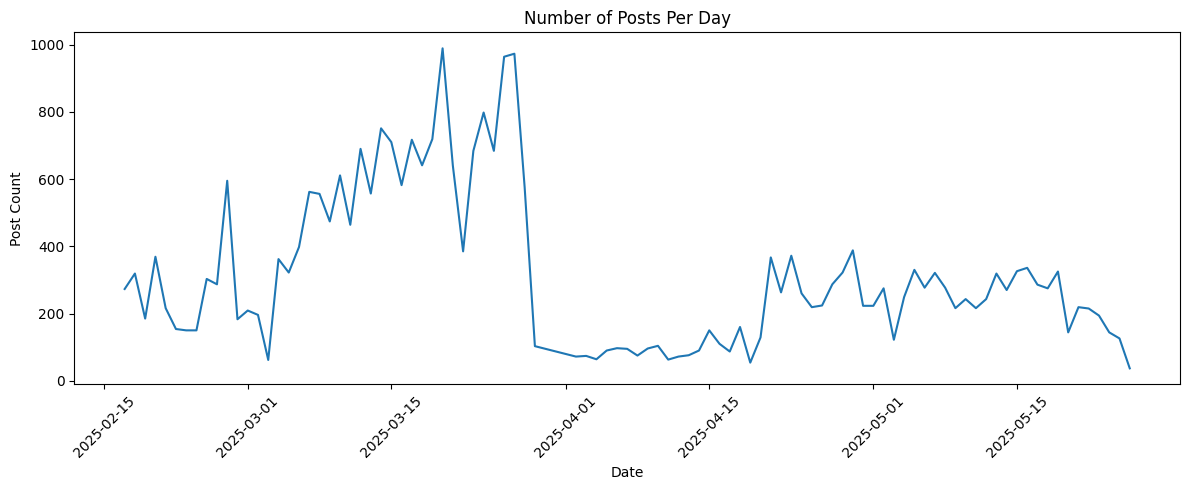

In [ ]:
posts_per_day = (
    df_comments[df_comments['createTimeISO'] >= pd.Timestamp.now(tz='UTC') - pd.Timedelta(days=365)]
    .groupby(df_comments['createTimeISO'].dt.date)
    .size()
)
plt.figure(figsize=(12, 5))
posts_per_day.plot()
plt.title("Number of Posts Per Day")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Cleaning

In [ ]:
import re
import stopwordsiso as stopwordsiso
import emoji

# Stopwortliste
langs = ["en", "de"]
extra_stopwords = ["im", "like", "thing", "ok", "got", "youre", "omg", "pls", "tbh", "smh", "aint"]
stopwords_list = set(
    word for lang in langs for word in (stopwordsiso.stopwords(lang) or [])
).union(extra_stopwords)

def clean_text_keep_emojis_remove_stopwords(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+", " ", text)  # URLs, Mentions entfernen
    text = emoji.replace_emoji(text, replace=lambda e, data: f" {e} ")  # Emojis isolieren
    text = re.sub(r"[^a-zA-ZäöüÄÖÜß0-9\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", " ", text)
    text = re.sub(r"\s+", " ", text)
    tokens = [t for t in text.split() if t not in stopwords_list and len(t) > 2]
    return " ".join(tokens)

In [ ]:
post_transcripts_eng_ger['transcribed_text'] = post_transcripts_eng_ger['transcribed_text'].apply(clean_text_keep_emojis_remove_stopwords)

#### Keyword and Trend extraction using TF-IDF 

TF-IDF (Term Frequency–Inverse Document Frequency): Computes importance of words by balancing frequency in a post vs. how unique they are across all posts. High TF-IDF terms in recent posts can indicate emerging buzzwords.
RAKE (Rapid Automatic Keyword Extraction): An unsupervised algorithm that finds key phrases by analyzing word frequency and co-occurrences in text​
analyticsvidhya.com
. It’s quick and domain-independent, useful for extracting multi-word phrases (e.g., “dewy skin”, “glass skin”).
KeyBERT: A BERT-based method that uses embeddings to find keywords that are most representative of a document’s meaning​
restack.io
. KeyBERT can generate more contextually relevant keywords by leveraging semantic understanding from the BERT model​
restack.io
. This is useful for capturing slang or nuanced phrases Gen Z might use.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from rake_nltk import Rake

from sklearn.feature_extraction.text import TfidfVectorizer

def extract_top_ngrams(texts, ngram_range=(2,3), top_n=20):
    vectorizer = TfidfVectorizer(
        max_features=100000,
        stop_words=None,
        ngram_range=ngram_range
    )
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # TF-IDF Score: Summe der TF-IDF Werte über alle Dokumente
    tfidf_scores = X.sum(axis=0).A1

    sorted_idx = tfidf_scores.argsort()[::-1]

    top_terms = [(feature_names[i], round(tfidf_scores[i], 4)) for i in sorted_idx[:top_n]]
    
    return top_terms

**Transcripts**

In [ ]:
top_unigrams = extract_top_ngrams(post_transcripts_eng_ger['transcribed_text'], ngram_range=(1,1), top_n=30)
print("Top Unirams:", top_unigrams)

top_bigrams = extract_top_ngrams(post_transcripts_eng_ger['transcribed_text'], ngram_range=(2,2), top_n=30)
print("Top Bigrams:", top_bigrams)

top_trigrams = extract_top_ngrams(post_transcripts_eng_ger['transcribed_text'], ngram_range=(3,3), top_n=30)
print("Top Trigrams:", top_trigrams)


top_4_gram = extract_top_ngrams(post_transcripts_eng_ger['transcribed_text'], ngram_range=(4,4), top_n=30)
print("Top 4-grams:", top_4_gram)

Top Unirams: [('music', 276.9976), ('skin', 163.0766), ('haut', 142.8773), ('skincare', 97.9142), ('love', 81.7814), ('routine', 74.868), ('einfach', 73.542), ('serum', 70.9749), ('cleanser', 49.6916), ('baby', 48.7087), ('toner', 48.6011), ('time', 47.0897), ('cream', 45.6417), ('gesicht', 45.4727), ('produkte', 42.6324), ('moisturizer', 42.5886), ('super', 40.0929), ('yeah', 39.8201), ('step', 39.8016), ('night', 39.7619), ('morning', 39.3373), ('feel', 38.657), ('gonna', 37.0997), ('care', 36.7496), ('vitamin', 36.337), ('benutze', 35.9054), ('creme', 35.5582), ('day', 34.9025), ('girl', 34.3441), ('leute', 34.1539)]
Top Bigrams: [('skincare routine', 42.404), ('watching anxiety', 20.5687), ('skin care', 20.425), ('speech detected', 16.8804), ('love love', 16.1225), ('yeah yeah', 13.2255), ('eye cream', 13.225), ('trockene haut', 13.1475), ('hyaluronic acid', 12.1425), ('steps steps', 10.2975), ('care routine', 9.5942), ('glass skin', 9.3221), ('dry skin', 9.2852), ('morning skincar

Bigrams and Trigrams are the most important ones for us. Unigrams are to general but 4-grams are to long and only include word repetitions. So we will continue with bigrams and trigrams.

In [ ]:
# only looking at posts from last 100 days
cutoff_date = post_transcripts_eng_ger['createTimeISO'].max() - pd.Timedelta(days=100)
recent_posts = post_transcripts_eng_ger[post_transcripts_eng_ger['createTimeISO'] >= cutoff_date]

top_keywords = extract_top_ngrams(recent_posts['transcribed_text'], ngram_range=(2,3), top_n=50)

clean_keywords = [ (phrase, count) for phrase, count in top_keywords if len(set(phrase.split())) > 1 ]

banned_phrases = ['speech video', 'speech detected']

clean_keywords = [phrase for phrase in clean_keywords if not any(banned in phrase for banned in banned_phrases)]

clean_keywords

[('watching anxiety', 19.2755),
 ('skincare routine', 14.8969),
 ('skin care', 6.8356),
 ('hyaluronic acid', 4.5963),
 ('perfect god', 4.1438),
 ('eye cream', 3.8922),
 ('trockene haut', 3.6679),
 ('sensitive skin', 3.4937),
 ('skin barrier', 3.399),
 ('morning skincare', 3.317),
 ('reine haut', 3.2222),
 ('ladies gentlemen', 3.1628),
 ('glass skin', 3.1463),
 ('anti aging', 3.0435),
 ('dry skin', 3.0034),
 ('korean skincare', 2.8408),
 ('care routine', 2.8196),
 ('lip balm', 2.6364),
 ('skin care routine', 2.5039),
 ('morning skincare routine', 2.4962),
 ('double cleanse', 2.481),
 ('empfindliche haut', 2.4427),
 ('cleansing oil', 2.2678),
 ('spendet feuchtigkeit', 2.2478),
 ('night time', 2.2473),
 ('aloe vera', 2.2311),
 ('anxiety watching', 2.1712),
 ('ready bed', 2.1602),
 ('unreine haut', 2.1421),
 ('skin glow', 2.0914),
 ('haut einfach', 2.0867),
 ('skincare produkte', 2.077),
 ('oil cleanser', 2.0442),
 ('god perfect', 2.0),
 ('supernova watch', 2.0),
 ('asmr morning', 2.0),
 (

This number is not the number of mentions but a weighted score by TF-IDF. TF-IDF penalizes words that appear very often as it's goal is to detect unsual, specific words and phrases. The value we are looking for depends on the total rows (text). 

In [ ]:
# extract interesting phrases
exclude = {"skincare routine", "skin care"}
tracked_phrases = [phrase for phrase, _ in clean_keywords if phrase not in exclude][:8]
#tracked_phrases.append("glass skin")

tracked_phrases

['watching anxiety',
 'hyaluronic acid',
 'perfect god',
 'eye cream',
 'trockene haut',
 'sensitive skin',
 'skin barrier',
 'morning skincare']

#### Trends over time

In [ ]:
# Filter: only include posts from 17.02.2025 onward
start_date = pd.to_datetime("2025-02-17", utc=True)
recent_posts = recent_posts[recent_posts["createTimeISO"] >= start_date]
recent_posts["date"] = pd.to_datetime(recent_posts["createTimeISO"]).dt.date

# 1. Extract date and count posts per day
posts_per_day = recent_posts.groupby("date").size()

# 2. Mark low-volume days (fewer than 20 posts)
low_activity_days = posts_per_day[posts_per_day < 20].index

# 3. Compute phrase trends
phrase_trends = {}

for phrase in tracked_phrases:
    matching = recent_posts["transcribed_text"].str.contains(phrase, case=False, na=False)
    daily_mentions = recent_posts[matching].groupby("date").size()
    normalized = (daily_mentions / posts_per_day) * 100
    phrase_trends[phrase] = normalized

# 4. Combine into DataFrame
trend_df_norm = pd.DataFrame(phrase_trends)

# 5. Fill real 0% values (phrase not mentioned)
trend_df_norm = trend_df_norm.fillna(0)

# 6. Reapply NaN for low-activity days
trend_df_norm.loc[low_activity_days] = np.nan

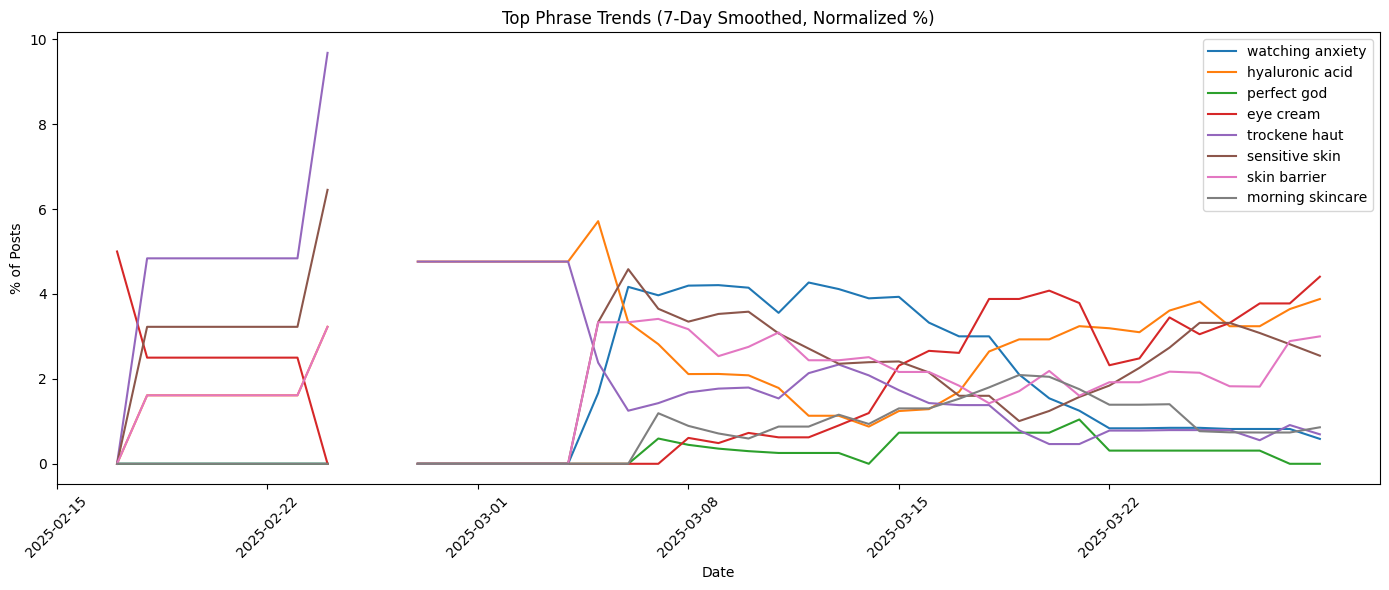

In [ ]:
#For daily graph
trend_df_smoothed = trend_df_norm.rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(14,6))
for phrase in tracked_phrases:
    plt.plot(trend_df_smoothed.index, trend_df_smoothed[phrase], label=phrase)

plt.title("Top Phrase Trends (7-Day Smoothed, Normalized %)")
plt.ylabel("% of Posts")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

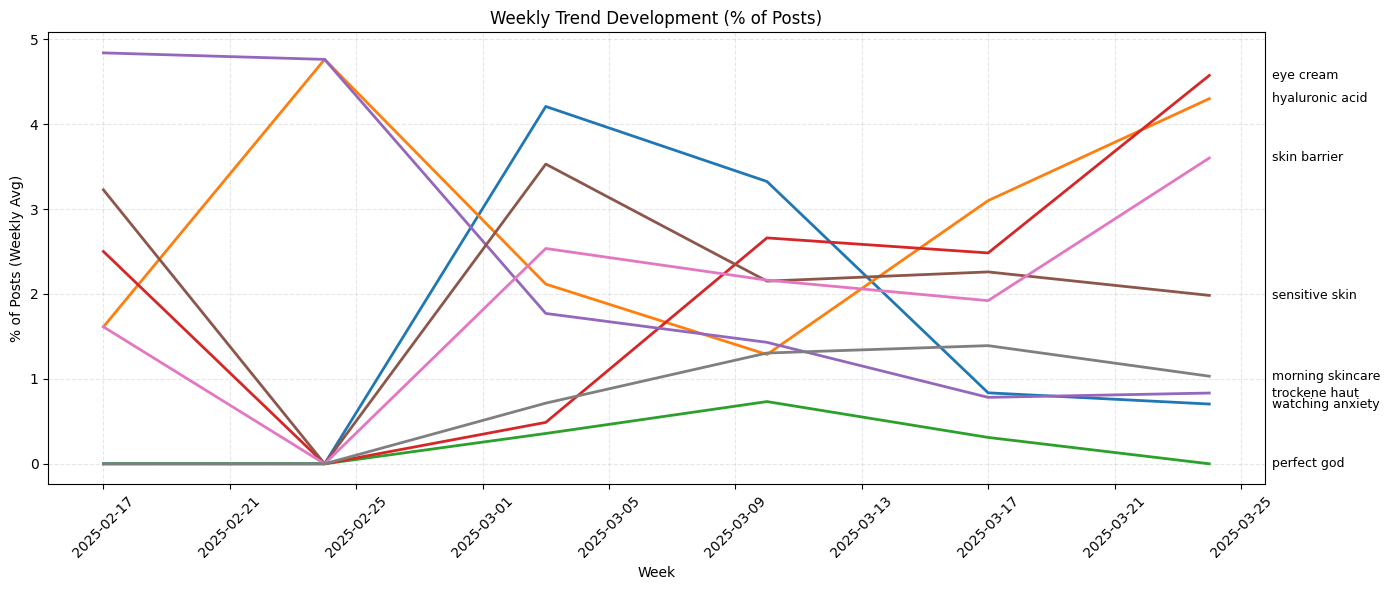

In [ ]:
trend_df_norm.index = pd.to_datetime(trend_df_norm.index)

# Group by calendar week and compute weekly average
weekly_avg = (
    trend_df_norm
    .groupby(trend_df_norm.index.to_period("W"))[tracked_phrases]
    .mean()
)

# Convert index to timestamp for plotting
weekly_avg.index = weekly_avg.index.to_timestamp()


# Plot with labels at the end of each line
plt.figure(figsize=(14, 6))

for phrase in tracked_phrases:
    plt.plot(weekly_avg.index, weekly_avg[phrase], linewidth=2)
    # Add label at the last point
    y_last = weekly_avg[phrase].iloc[-1]
    plt.text(
        weekly_avg.index[-1] + pd.Timedelta(days=2),
        y_last,
        phrase,
        fontsize=9,
        verticalalignment='center'
    )

plt.title("Weekly Trend Development (% of Posts)")
plt.ylabel("% of Posts (Weekly Avg)")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

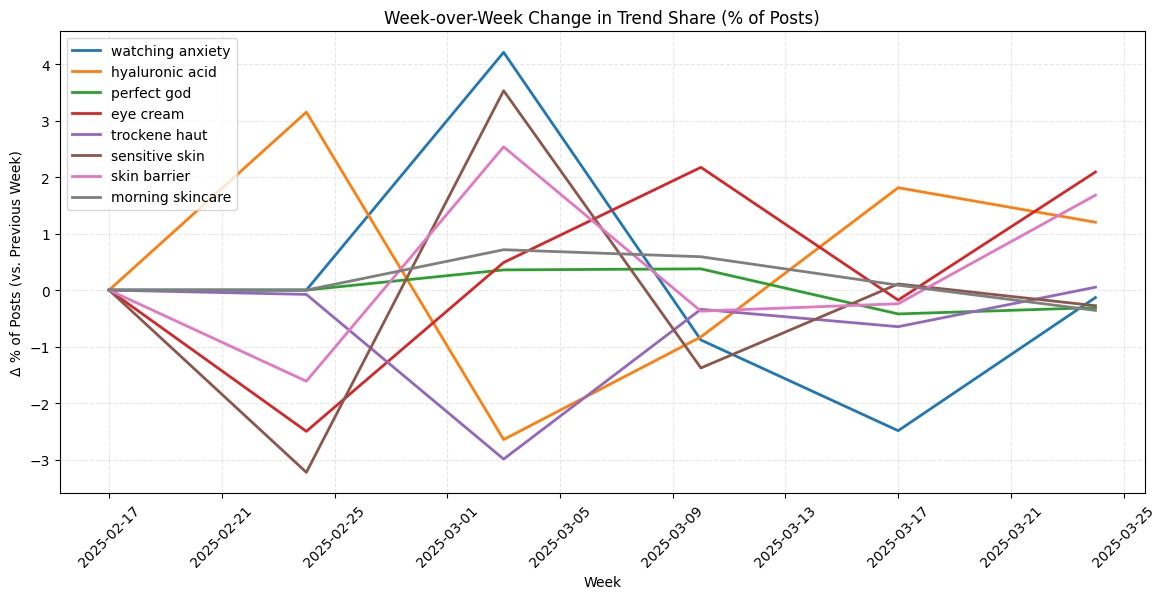

In [ ]:
# Compute week-over-week change
weekly_change = weekly_avg.diff().fillna(0)

plt.figure(figsize=(14, 6))

for phrase in tracked_phrases:
    plt.plot(weekly_change.index, weekly_change[phrase], linewidth=2, label=phrase)

plt.title("Week-over-Week Change in Trend Share (% of Posts)")
plt.ylabel("Δ % of Posts (vs. Previous Week)")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.show()

#### Sentiment analysis on comments over time on top trends

How does Gen Z talk about the trends in the comments? 

In [ ]:
comments_with_posts_ger_eng = pd.read_csv("../data/comments_with_posts_ger_eng.csv")

complete_df = pd.merge(
    comments_with_posts_ger_eng,
    post_transcripts[['post_id','transcribed_text', 'video_description']],
    left_on='post_id',
    right_on='post_id',
    how='inner'  
)

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_17406/875410351.py:1: DtypeWarning:

Columns (11,33) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
comments_with_posts_ger_eng

,post_id,comment_id,comment_createTimeISO_comment,text_comment,diggCount_comment,replyCommentTotal_comment,uniqueId_comment,id,text,textLanguage,...,music_name,music_author,video_duration,video_definition,effect_sticker_names,effect_sticker_useCounts,detailed_mentions_nicknames,location_address,sentiment,confidence
0,7485449276689091845,7485763126596846391,2025-03-25T15:04:30.000Z,"""im gonna move my car then you park there""me:i...",1896,20,ngelozimahlangu,7485449276689091845,Let’s go on a road trip🌸🎀 We traveled to a bea...,en,...,Ototo,Asake,237,480p,[],[],[],NaN,neutral,0.760314
1,7485449276689091845,7485627796623754039,2025-03-25T06:19:58.000Z,give me two years and 20 hours!,970,14,ruthmseleku,7485449276689091845,Let’s go on a road trip🌸🎀 We traveled to a bea...,en,...,Ototo,Asake,237,480p,[],[],[],NaN,neutral,0.611229
2,7485449276689091845,7485757818222740279,2025-03-25T14:43:58.000Z,May this type of friendship attack me😭♥️,2973,18,vukona_6,7485449276689091845,Let’s go on a road trip🌸🎀 We traveled to a bea...,en,...,Ototo,Asake,237,480p,[],[],[],NaN,positive,0.714172
3,7485449276689091845,7485634830261650181,2025-03-25T06:47:17.000Z,Chelete e monate hle bathong🥺🙌🏽,7160,28,leend76,7485449276689091845,Let’s go on a road trip🌸🎀 We traveled to a bea...,en,...,Ototo,Asake,237,480p,[],[],[],NaN,positive,0.964078
4,7485449276689091845,7485623097333465862,2025-03-25T06:01:30.000Z,People travel with a Bag and a tote. Can never...,193,15,ethelkgare,7485449276689091845,Let’s go on a road trip🌸🎀 We traveled to a bea...,en,...,Ototo,Asake,237,480p,[],[],[],NaN,neutral,0.558522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54232,7350335395231517994,7350397069083280174,2024-03-25T20:14:58.000Z,Does it work,71,6,dididjns,7350335395231517994,Anua has great skincare products for beginners...,en,...,Righteous x Yummy - Sped Up,Tazzy,60,540p,[],[],[],NaN,neutral,0.752999
54233,7326585323385916715,7328815115359437574,2024-01-27T16:25:51.000Z,girll tretinoin saved my life,1,6,jian521,7326585323385916715,soo easy and so effective! #acne #skintok #ski...,en,...,super shy ft. nicki minaj,numbkarina.,26,540p,[],[],[],NaN,positive,0.779343
54234,7486279791402896670,7486305430474687278,2025-03-27T02:08:50.000Z,You should exfoliate before toner because now ...,57,6,lyscolombi,7486279791402896670,ur looking a bit crusty 🧖🧴🤍 let me overexplain...,en,...,original sound,Jocie,89,540p,"[Lite Foundation,makeup,Inverted]","[0,0,0]",[],NaN,neutral,0.485495
54235,7486279791402896670,7487313991221363461,2025-03-29T19:22:42.000Z,Ella de que pais es? 😭💗,10,6,valerin._12,7486279791402896670,ur looking a bit crusty 🧖🧴🤍 let me overexplain...,en,...,original sound,Jocie,89,540p,"[Lite Foundation,makeup,Inverted]","[0,0,0]",[],NaN,positive,0.860353


In [ ]:
def filter_recent(df, date_col="createTimeISO", days=300):
    # Ensure datetime is timezone-aware and comparable
    df[date_col] = pd.to_datetime(df[date_col], utc=True, errors="coerce")
    start_date = pd.Timestamp.utcnow() - timedelta(days=days)
    return df[df[date_col] >= start_date].copy()


def add_phrase_flags(df, phrases, text_col, prefix=""):
    for phrase in phrases:
        col_name = f"{prefix}{phrase}"
        df[col_name] = df[text_col].str.contains(phrase, case=False, na=False)
    return df

def calculate_trend_sentiment(df, phrases, prefix="", sentiment_col="sentiment"):
    trend_sentiment = {}
    for phrase in phrases:
        subset = df[df[f"{prefix+phrase}"]]
        sentiment_counts = subset[sentiment_col].value_counts(normalize=True)
        trend_sentiment[phrase] = sentiment_counts
    return trend_sentiment

def prepare_time_series(df, date_col="createTimeISO"):
    df["date"] = pd.to_datetime(df[date_col]).dt.to_period("W").dt.to_timestamp()
    return df

def compute_sentiment_over_time(df, phrase, prefix="", sentiment_col="sentiment"):
    # All comments for volume
    df_phrase = df[df[f"{prefix+phrase}"]].copy()
    df_phrase["date"] = pd.to_datetime(df_phrase["createTimeISO"]).dt.to_period("W").dt.to_timestamp()

    # Only high-confidence comments for sentiment share
    df_confident = df_phrase[df_phrase["confidence"] >= 0.7]

    # Compute sentiment share from confident subset
    counts = df_confident.groupby(["date", "sentiment"]).size().unstack(fill_value=0)
    shares = counts.div(counts.sum(axis=1), axis=0)

    # Compute total volume from all data
    volume = df_phrase.groupby("date").size()
    
    return shares, volume

def plot_sentiment_and_volume(shares, volume, phrase):
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    shares.plot(kind="bar", stacked=True, ax=ax1, color=["red", "lightgrey", "green"], width=0.8)
    ax1.set_ylabel("Share of Comments")
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Week")
    ax1.set_xticklabels(shares.index.strftime("%b %d"), rotation=45)
    ax1.legend(title="Sentiment", loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(volume.index.strftime("%b %d"), volume.values, color="black", marker="o", linewidth=2, label="Total Comments")
    ax2.set_ylabel("Total Comments")
    ax2.tick_params(axis='y', labelcolor="black")

    plt.title(f"Sentiment Share (Filtered by Confidence ≥ 0.7) vs. Total Comment Volume for '{phrase}'")
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()


In [ ]:
def compute_weekly_sentiment(df, phrases, date_col="date", prefix="", sentiment_col="sentiment", sentiments=["positive", "negative"]):
    weekly_sentiment = {}
    for phrase in phrases:
        subset = df[df[f"{prefix+phrase}"]].copy()
        if subset.empty:
            continue

        counts = subset.groupby([date_col, sentiment_col]).size().unstack(fill_value=0)
        proportions = counts.div(counts.sum(axis=1), axis=0)

        # Keep only the specified sentiments
        weekly_sentiment[phrase] = proportions[sentiments]
    return weekly_sentiment

def plot_weekly_sentiment(weekly_sentiment, smoothing_window=0):
    for phrase, df in weekly_sentiment.items():
        df_to_plot = df.rolling(window=smoothing_window, min_periods=1).mean() if smoothing_window > 1 else df

        df_to_plot.plot(title=f"Sentiment Over Time: {phrase}", color=["green", "red"], figsize=(12, 4))
        plt.ylabel("Sentiment Share")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.show()


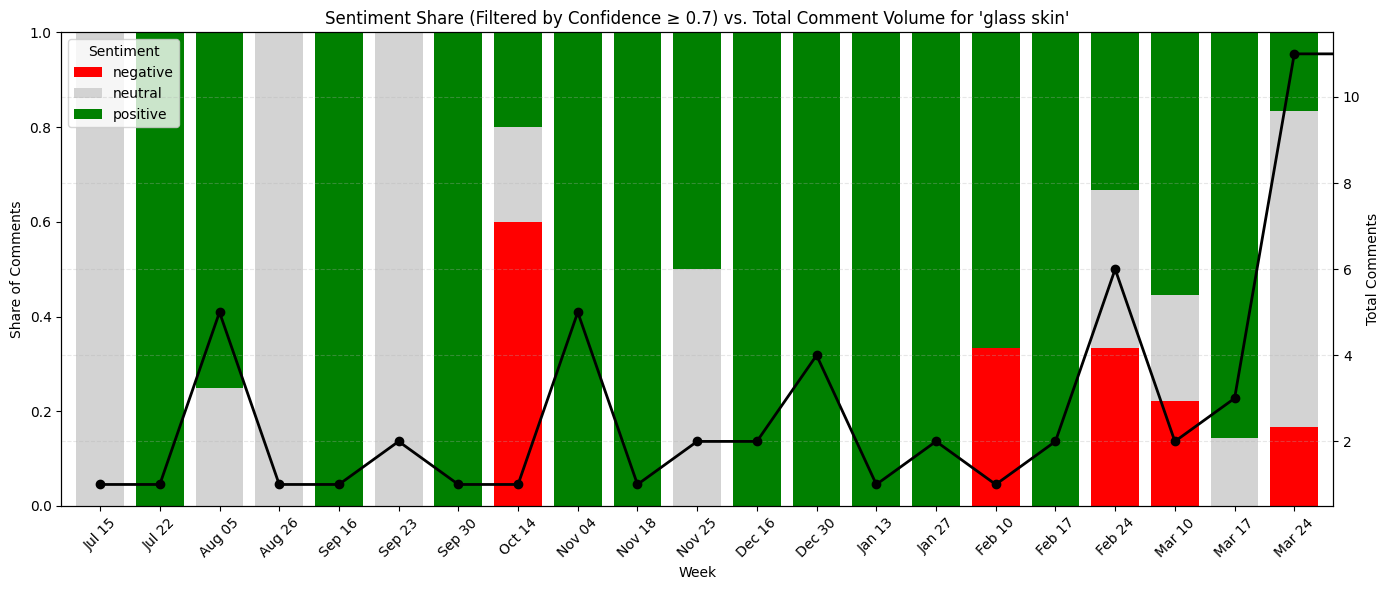

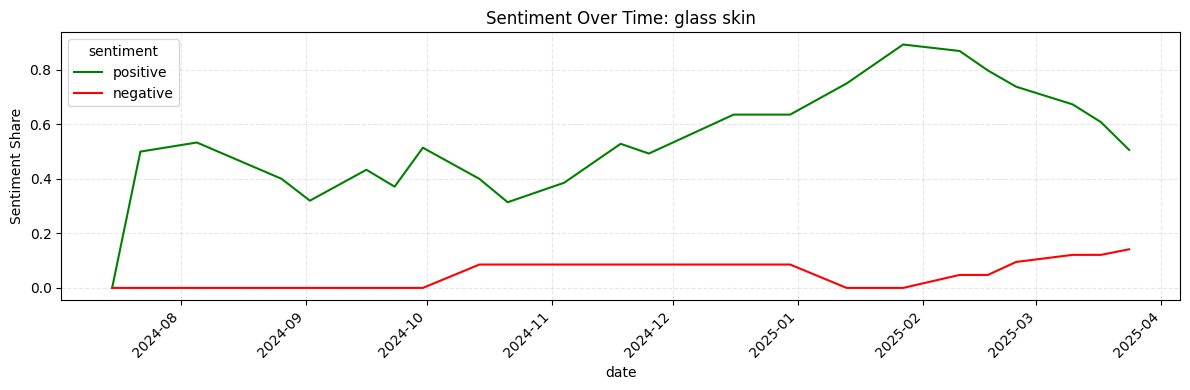

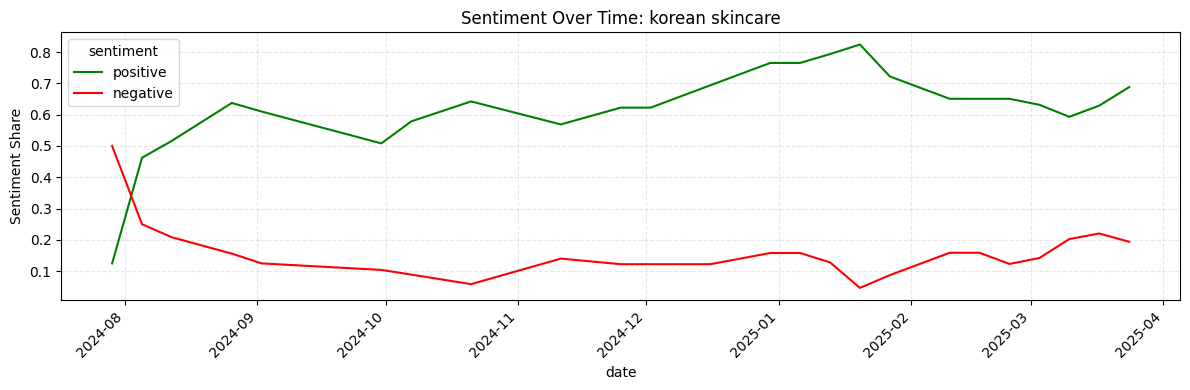

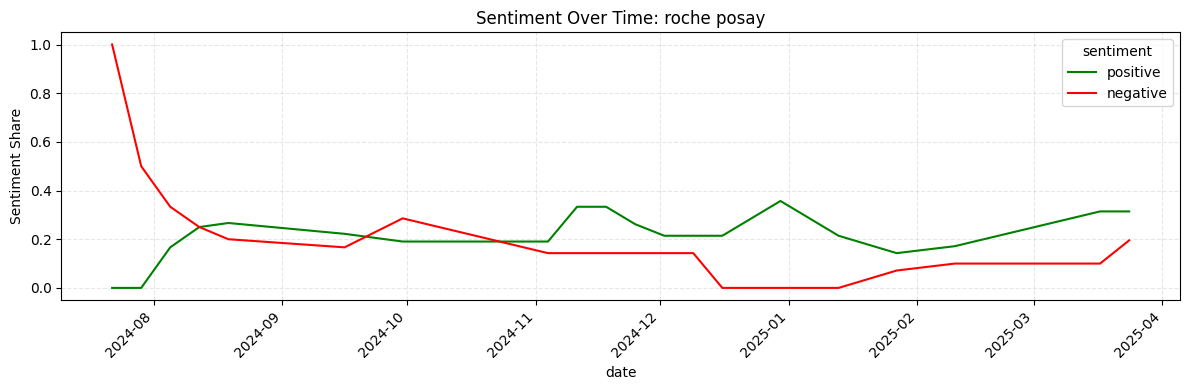

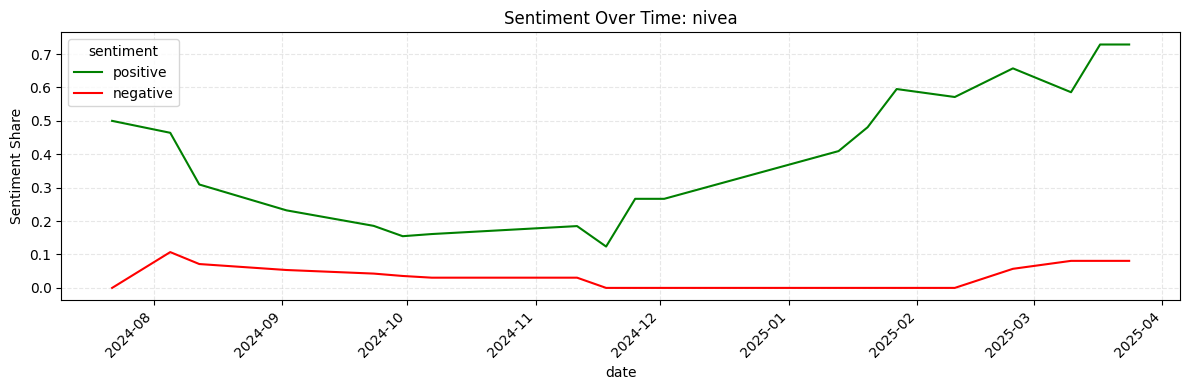

In [ ]:
prefix="comment_has_"
recent_comments= filter_recent(complete_df, days=300)

trend_phrases = ["glass skin", "korean skincare", "roche posay", "nivea"]

recent_comments = add_phrase_flags(recent_comments, trend_phrases, text_col="text_comment", prefix=prefix)
trend_sentiment = calculate_trend_sentiment(recent_comments, trend_phrases, prefix=prefix)
recent_comments = prepare_time_series(recent_comments)

# For one phrase:
phrase = "glass skin"
shares, volume = compute_sentiment_over_time(recent_comments,prefix=prefix, phrase = phrase)
plot_sentiment_and_volume(shares, volume, phrase)

weekly_sentiment = compute_weekly_sentiment(recent_comments, trend_phrases, prefix=prefix)
plot_weekly_sentiment(weekly_sentiment, smoothing_window=7)

#### Sentiment for posts for trends

In [ ]:
recent_comments['text']

0        Yes, in 7 days #skincare #skintok #kbeauty #ko...
5        Lasst uns hier mal austauschen....  Mein absol...
7        Giving my skin a break is all it needed🥹😌 #hai...
8        Giving my skin a break is all it needed🥹😌 #hai...
9        Giving my skin a break is all it needed🥹😌 #hai...
                               ...                        
47687    Anzeige | Trockene Haut? Nicht mit dem LIPIKAR...
47688    Go to bed old, wake up hot!!! ✨ . #morningshed...
47693    ur looking a bit crusty 🧖🧴🤍 let me overexplain...
47694    ur looking a bit crusty 🧖🧴🤍 let me overexplain...
47695    Arencia Fresh Green Rice Mochi Cleanser deep c...
Name: text, Length: 26840, dtype: object

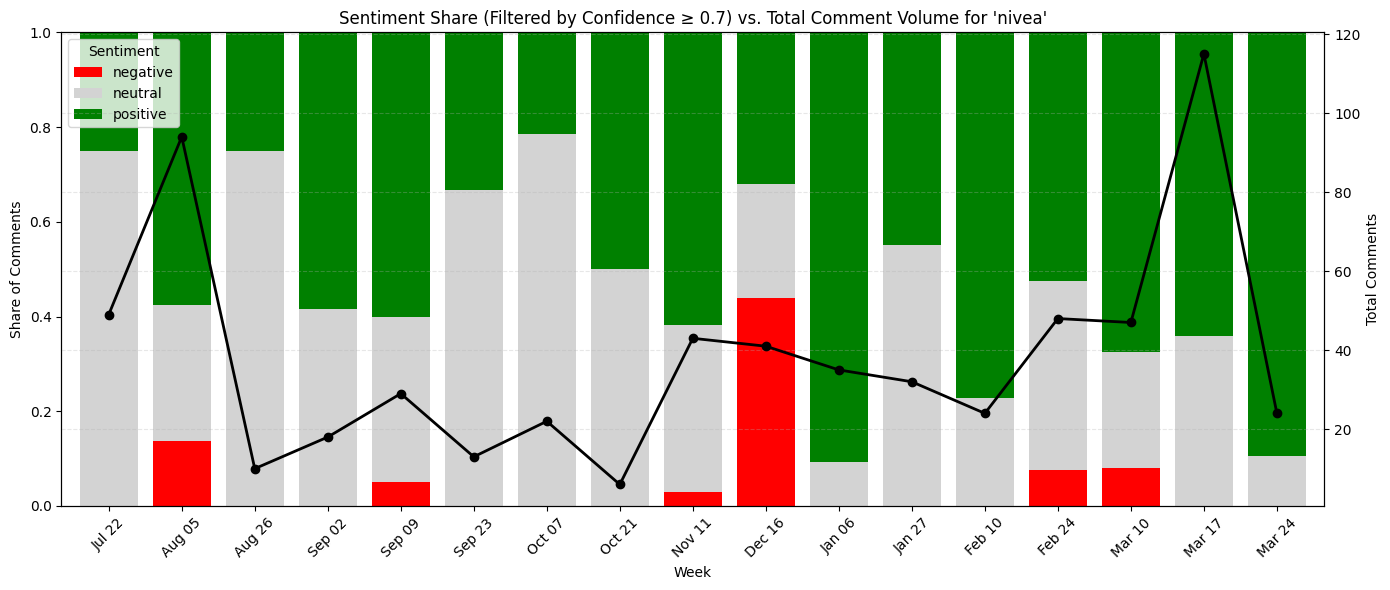

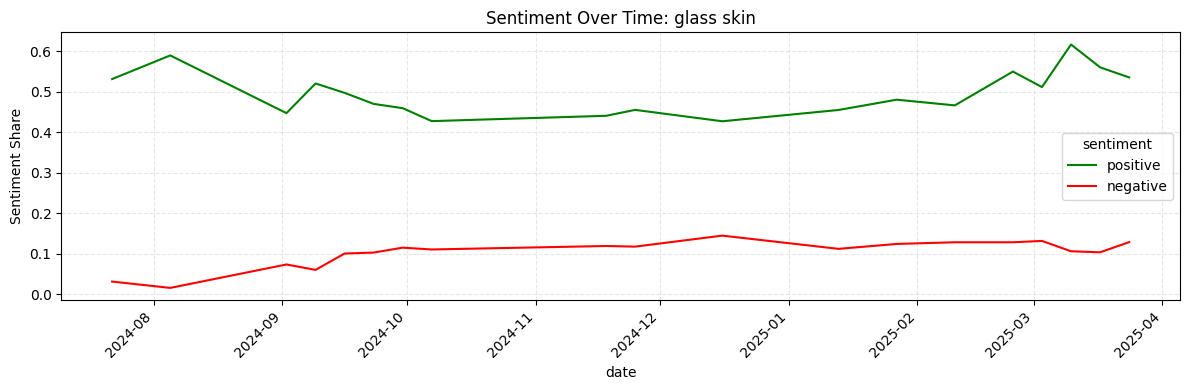

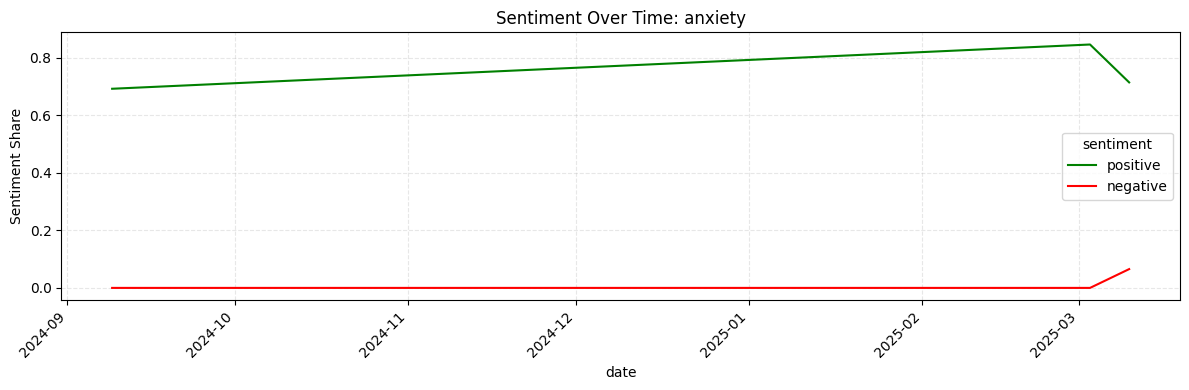

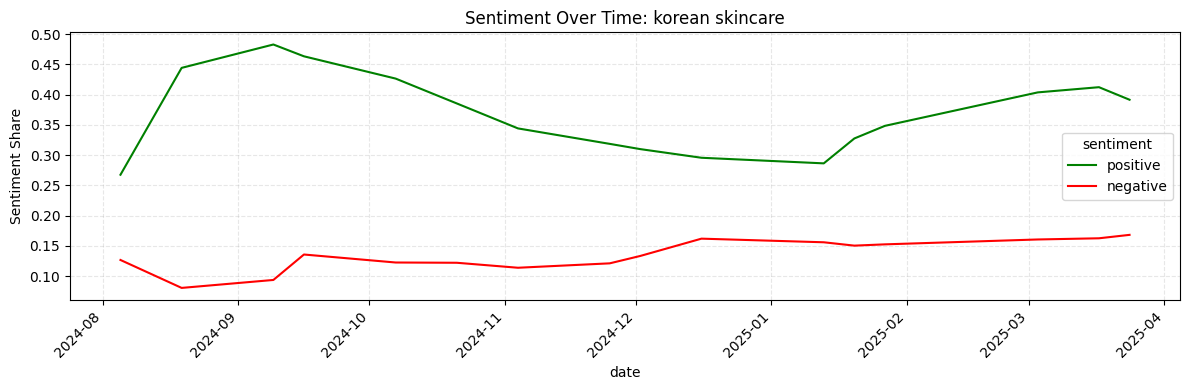

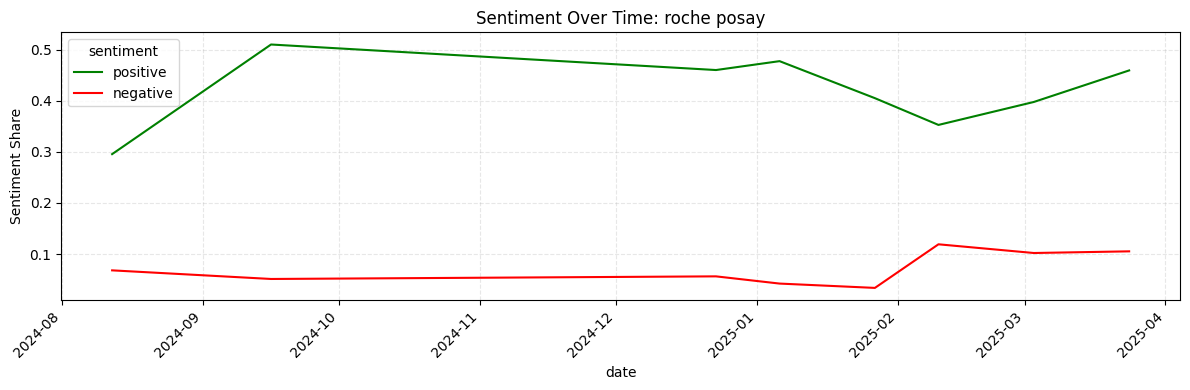

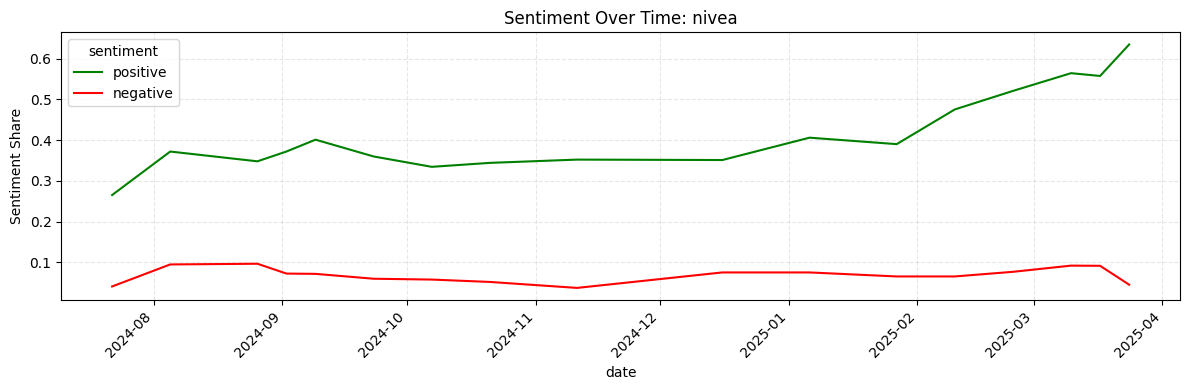

In [ ]:
recent_comments= filter_recent(complete_df, days=300)
trend_phrases = ["glass skin", "anxiety", "korean skincare", "roche posay", "nivea"]

recent_comments_posts_sentiment = add_phrase_flags(df=recent_comments, prefix="caption_has_", phrases=trend_phrases, text_col="text")
recent_comments_posts_sentiment = add_phrase_flags(df=recent_comments, prefix="transcript_has_", phrases=trend_phrases, text_col="transcribed_text")

for phrase in trend_phrases:
    recent_comments_posts_sentiment[f"post_has_{phrase}"] = recent_comments_posts_sentiment[f"caption_has_{phrase}"] | recent_comments_posts_sentiment[f"transcript_has_{phrase}"]


trend_sentiment = calculate_trend_sentiment(df=recent_comments_posts_sentiment, phrases=trend_phrases, prefix="post_has_")
recent_comments_posts_sentiment = prepare_time_series(recent_comments_posts_sentiment)

# For one phrase:
phrase = "nivea"
shares, volume = compute_sentiment_over_time(df=recent_comments_posts_sentiment, phrase=phrase, prefix="post_has_")
plot_sentiment_and_volume(shares, volume, phrase)

weekly_sentiment = compute_weekly_sentiment(df=recent_comments_posts_sentiment, phrases=trend_phrases, prefix="post_has_")
plot_weekly_sentiment(weekly_sentiment, smoothing_window=7)

#### Reach of trends

In [ ]:
def compute_trend_time_series_with_average(
    df,
    phrases,
    date_col,
    view_col="playCount",
    prefix="",
):
    df["date"] = pd.to_datetime(df[date_col]).dt.to_period("W").dt.to_timestamp()
    results = []

    for phrase in phrases:
        col = f"{prefix+phrase}"
        if col not in df.columns:
            continue

        subset = df[df[col]]
        if subset.empty:
            continue

        # Group by date and compute total + count
        grouped = subset.groupby("date")[view_col].agg(
            total_views="sum",
            post_count="count"
        ).reset_index()

        grouped["avg_views_per_post"] = grouped["total_views"] / grouped["post_count"]
        grouped["trend"] = phrase
        results.append(grouped)

    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()

def plot_trend_metric_over_time(df, value_col, title, ylabel):
    plt.figure(figsize=(14, 6))
    for phrase in df["trend"].unique():
        trend_data = df[df["trend"] == phrase]
        plt.plot(trend_data["date"], trend_data[value_col], marker="o", label=phrase)

    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlabel("Week")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


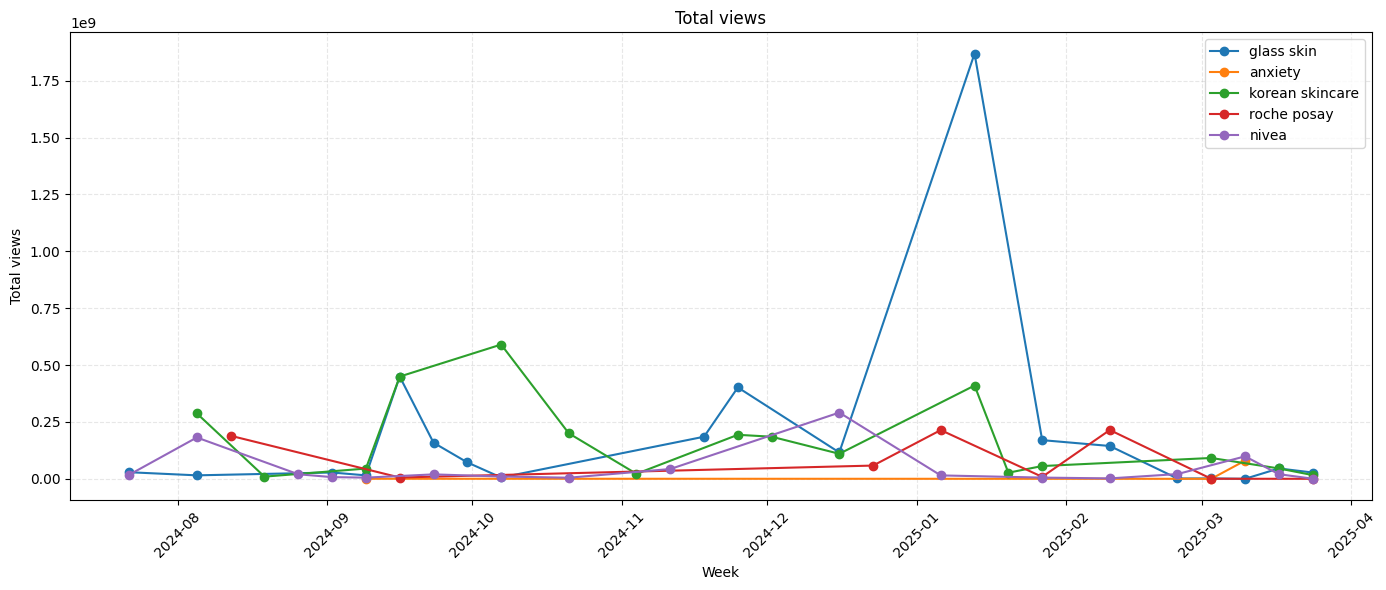

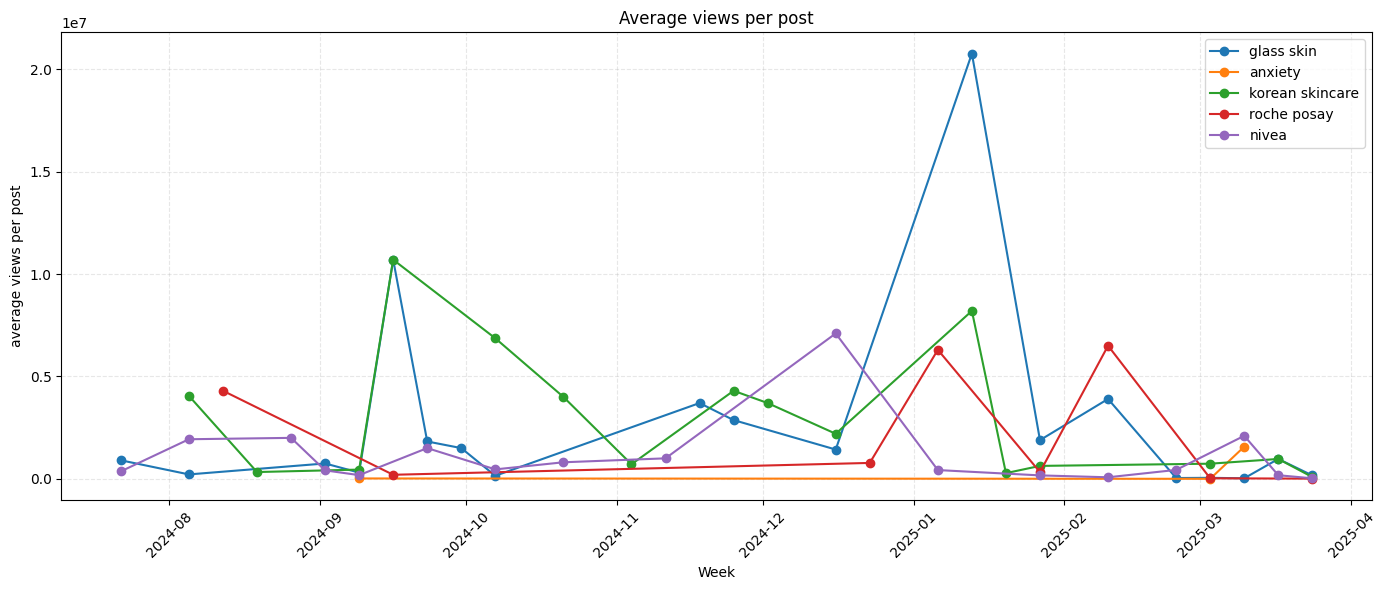

In [ ]:
reach_overtime = compute_trend_time_series_with_average(recent_comments, trend_phrases, date_col="createTimeISO", prefix="post_has_")
plot_trend_metric_over_time(df=reach_overtime, value_col= "total_views", title="Total views", ylabel="Total views")
plot_trend_metric_over_time(df=reach_overtime, value_col= "avg_views_per_post", title="Average views per post", ylabel="average views per post")


In [ ]:
def compute_trend_view_stats(df, phrases, view_col="playCount", text_col="text_post", prefix=""):
    
    # Compute view statistics
    data = []
    for phrase in phrases:
        flag_col = f"{prefix+phrase}"
        subset = df[df[flag_col]]
        total_views = subset[view_col].sum()
        post_count = len(subset)
        avg_views = total_views / post_count if post_count > 0 else 0
        data.append({
            "trend": phrase,
            "total_views": total_views,
            "post_count": post_count,
            "avg_views_per_post": avg_views
        })

    return pd.DataFrame(data).sort_values(by="total_views", ascending=False)

In [ ]:
view_stats_df = compute_trend_view_stats(recent_comments_posts_sentiment, trend_phrases, prefix="post_has_")
print(view_stats_df)


             trend  total_views  post_count  avg_views_per_post
0       glass skin   3735083770        1183        3.157298e+06
2  korean skincare   2738846603        1149        2.383679e+06
4            nivea    763233772         650        1.174206e+06
3      roche posay    690619551         258        2.676820e+06
1          anxiety     80228253          65        1.234281e+06


#### Caption and Hashtags analysis

In [ ]:
recent_posts['text']

4       Wenn man bedenkt dass die Frau fast 70 Jahre a...
5       Do your skin a favor and just try it💕 #beauty ...
8       #NeutrogenaPartner my go-to pimple patch routi...
11      skincare masterclass w @Shani Darden 🫧 new fav...
12      POV: us since @CVS Pharmacy Epic Beauty Sale™ ...
                              ...                        
5481    How to remove tiny white bumps (closed comedon...
5482    My Korean skincare routine looks like this lat...
5484    ummm… THIS PR BOX?!🫢👏🏼📦 time for my honesty….....
5485    @epicderm.de 🫶🏼 #skinprep#prepmyskin#grwm#skin...
5486    Mother daughter skincare routine using my favo...
Name: text, Length: 1396, dtype: object

In [ ]:
# only looking at posts from last x days
cutoff_date = post_transcripts_eng_ger['createTimeISO'].max() - pd.Timedelta(days=40)
recent_posts = post_transcripts_eng_ger[post_transcripts_eng_ger['createTimeISO'] >= cutoff_date]
top_keywords = extract_top_ngrams(recent_posts['text'], ngram_range=(2,4), top_n=40)

clean_keywords = [ (phrase, count) for phrase, count in top_keywords if len(set(phrase.split())) >= 1 ]

banned_phrases = ['speech video', 'speech detected']

clean_keywords = [phrase for phrase in clean_keywords if not any(banned in phrase for banned in banned_phrases)]

clean_keywords

[('skincare routine', 12.2926),
 ('skincare skincareroutine', 9.5141),
 ('deine haut', 5.157),
 ('die haut', 4.1203),
 ('skincare hautpflege', 4.0739),
 ('fyp skincare', 3.7353),
 ('skincare skincaretips', 3.3446),
 ('fyp foryou', 3.2491),
 ('korean skincare', 3.155),
 ('skin care', 3.1489),
 ('morning skincare', 3.0455),
 ('make up', 2.9773),
 ('routine skincare', 2.9433),
 ('wenn du', 2.9061),
 ('my skin', 2.8484),
 ('in der', 2.8458),
 ('skincareroutine skincaretips', 2.8249),
 ('morning skincare routine', 2.7917),
 ('my skincare', 2.7858),
 ('grwm skincare', 2.7747),
 ('skincareroutine skincare', 2.7717),
 ('meine haut', 2.7254),
 ('medicube global', 2.7129),
 ('replying to', 2.5816),
 ('hautpflege skincare', 2.5039),
 ('skincare fyp', 2.4646),
 ('strahlende haut', 2.3676),
 ('my skincare routine', 2.3524),
 ('skincare koreanskincare', 2.3362),
 ('makeup skincare', 2.2099),
 ('skincare routine skincare', 2.1937),
 ('skin skincare', 2.0947),
 ('skincare beauty', 2.0889),
 ('hautpfle

**Keywords over time**

In [ ]:
# clean_keywords enthält jetzt [(phrase, count), ...]
#tracked_phrases = [phrase for phrase, _ in clean_keywords]

tracked_phrases=['glass skin', 'skincare routine', 'la roche','korean skincare','skincare makeup', 'medicube global' ]

In [ ]:
keyword_timeseries = pd.DataFrame()

# Für jeden Phrase: zählen, wie oft er pro Tag vorkommt
for phrase in tracked_phrases:
    counts = (recent_posts
              .assign(found=recent_posts['text'].str.contains(phrase, case=False, na=False))
              .groupby(recent_posts['createTimeISO'].dt.date)['found']
              .sum()
             )
    keyword_timeseries[phrase] = counts

# Fehlende Tage mit 0 auffüllen
keyword_timeseries = keyword_timeseries.fillna(0)

# Posts pro Tag zählen
posts_per_day = recent_posts.groupby(recent_posts['createTimeISO'].dt.date).size()

# Jetzt Trendzählungen normieren
keyword_timeseries_norm = keyword_timeseries.div(posts_per_day, axis=0) * 100  # Prozentuale Häufigkeit
keyword_timeseries_norm[posts_per_day == 0] = np.nan  # Set 0-post days to NaN


#### RAKE on latest posts

In [ ]:
from rake_nltk import Rake
from collections import Counter

def extract_trending_phrases(posts_df, days_back=7, top_n_phrases_per_post=3, top_trends=10, min_words=2, max_words=5):
    """
    Extrahiere die wichtigsten Phrasen aus den neuesten Posts mit RAKE.
    
    Args:
        posts_df (pd.DataFrame): DataFrame mit Spalte 'transcribed_text' und 'createTimeISO'
        days_back (int): Wieviele Tage zurück betrachtet werden sollen
        top_n_phrases_per_post (int): Wie viele Top-Phrasen pro Post extrahieren
        top_trends (int): Wie viele Trends am Ende ausgeben
        
    Returns:
        list: Liste der wichtigsten Trend-Phrasen
    """
        
    # Filter: Only posts of the last `days_back` days
    recent_posts = posts_df[posts_df['createTimeISO'] >= (posts_df['createTimeISO'].max() - pd.Timedelta(days=days_back))]
    
    r = Rake()
    all_key_phrases = []
    
    for text in recent_posts['transcribed_text']:
        if isinstance(text, str) and text.strip() != "":
            r.extract_keywords_from_text(text)
            key_phrases = r.get_ranked_phrases()[:top_n_phrases_per_post]
            # Only phrases with 2-5 words
            filtered_phrases = [phrase for phrase in key_phrases if min_words <= len(phrase.split()) <= max_words]
            all_key_phrases.extend(filtered_phrases)

    phrase_counts = Counter(all_key_phrases)
    trending_phrases = phrase_counts.most_common(top_trends)
    
    return trending_phrases


In [ ]:
top_phrases = extract_trending_phrases(post_transcripts_eng_ger, days_back=30, top_n_phrases_per_post=3, top_trends=20)

top_phrases = [phrase for phrase in top_phrases if not any(banned in phrase for banned in banned_phrases)] #filter out "speech detected" and "speech video"

top_phrases = [ (phrase, count) for phrase, count in top_phrases if count >= 3 ] #filter out phrases with less than 3 mentions

top_phrases

[('watching anxiety', 16), ('perfect god', 3), ('funny bad skin', 3)]

#### Bert topic

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import stopwordsiso as stopwordsiso
from hdbscan import HDBSCAN

# Create custom count vectorizer model
vectorizer_model = CountVectorizer(stop_words=None)

hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=4, metric='euclidean')

# Use sentence-transformers model (fast and great for social data)
embedding_model = SentenceTransformer("all-mpnet-base-v2")  #all-MiniLM-L6-v2

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model,language="multilingual")

In [ ]:
#topics, probs = topic_model.fit_transform(recent_posts['transcribed_text'])

In [ ]:
topic_info = topic_model.get_topic_info()
#-1 are outliers

topic_info.iloc[1]['Representative_Docs']

topic_info
topic_info[topic_info.Topic != -1].sort_values("Count", ascending=False).head(20)


ValueError: This BERTopic instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.